In [1]:
# TODO
#
# [ ] 1. load Perch model
# [ ] 2. convert to pytorch (quick try)
# [ ] 3. load soundscapes and annotations
# [ ] 4. compute embeddings using Perch model

# [x] 1-4. compute embeddings using BirdNET-Analyzer
# [ ] 5. create initial AL datasets
# [ ] 6. compute prototypes
# [ ] 7. compute decision boundaries for test soundscapes
# [ ] 8. visualize decision boundaries and soundscapes
# [ ] 9. simulate AL for loaded soundscapes
# [ ]     10. redo 5-8 in this loop
# [ ] 11. create animation for uncertainty curves 
# [ ] 12. migrate draft code to python scripts with ray-rune

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import glob
import tqdm
import librosa
import torch
import torchaudio
import numpy as np
import time

import datasets
import oracles
           
import stats_utils


import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum(np.power(x1-x2, 2)))

def probability_query(query_embedding, n_prototype, p_prototype, temp=1):
    """
    The pseudo-probability of the query point belonging to the positive class.
    """
    d_n = euclidean_distance(query_embedding, n_prototype)
    d_p = euclidean_distance(query_embedding, p_prototype)

    y_proba_p = np.exp(-d_p / temp) / (np.exp(-d_p/temp) + np.exp(-d_n/temp))
    
    return y_proba_p

In [4]:
def load_annotated_embeddings(base_dir):
    dataset = datasets.FixedQueryActiveLearningDataset(base_dir)
    oracle = oracles.WeakLabelOracle(base_dir)

    all_embeddings = []
    all_labels = []
    all_info = []
    
    #while dataset.count_unlabeled() > 0:
    for key in dataset.labeled_train_data.keys():
        for idx in range(len(dataset.labeled_train_data[key])):
            #print(key, idx)
            (start_time, end_time, embedding) = dataset.train_data[key][idx]
        #(soundscape_basename, idx), (start_time, end_time, embedding) = dataset.random_query()
        # annotate query
            label = oracle.query(start_time, end_time, key)
            # update active learning dataset with label
            dataset.add_query_label(key, idx, label)
            all_embeddings.append(embedding)
            all_labels.append(label)
            all_info.append((key, idx, start_time, end_time))

    all_embeddings = np.array(all_embeddings)
    all_labels = np.array(all_labels)

    return all_embeddings, all_labels, all_info

In [5]:
def online_average(x_prev_average, x_curr, n):
    return x_prev_average + (x_curr - x_prev_average) / n

def random_active_learning_simulation(train_base_dir, test_base_dir, n_iterations, batch_size=1):
    test_embeddings, test_labels, _ = load_annotated_embeddings(test_base_dir)

    #print("train dir: ", train_base_dir)
    #print("test dir: ", test_base_dir)
    
    # state
    all_embeddings = []
    all_labels = []
    
    oracle = oracles.WeakLabelOracle(train_base_dir)
    train_dataset = datasets.FixedQueryActiveLearningDataset(train_base_dir)
    
    iteration_count = 0

    accuracies = np.zeros(n_iterations)
    random_accuracies = np.zeros(n_iterations)
    probas = np.zeros((n_iterations, len(test_embeddings)))

    embedding_dim = 1024
    n_prototype = np.zeros(embedding_dim)
    p_prototype = np.zeros(embedding_dim)
    count_negative = 0
    count_positive = 0
    
    while train_dataset.count_unlabeled() > 0:
        #print("unlabaled datapoints: ", train_dataset.count_unlabeled())

        test_predictions = []
        for idx_emb, query_embedding in enumerate(test_embeddings):
            proba = probability_query(query_embedding, n_prototype=n_prototype, p_prototype=p_prototype, temp=1)
            probas[iteration_count, idx_emb] = proba
            test_predictions.append(int(proba >= 0.5))
        test_predictions = np.array(test_predictions)

        accuracy = sklearn.metrics.f1_score(test_predictions, test_labels)
        random_accuracy = sklearn.metrics.f1_score(np.random.choice([0, 1], size=len(test_labels)), test_labels)
            
        random_accuracies[iteration_count] = random_accuracy
        accuracies[iteration_count] = accuracy
        
        for _ in range(batch_size):
            # get random query
            (soundscape_basename, idx), (start_time, end_time, embedding) = train_dataset.random_query()
            # annotate query
            label = oracle.query(start_time, end_time, soundscape_basename)
            # update active learning dataset with label
            train_dataset.add_query_label(soundscape_basename, idx, label)
    
            # online average of prototypes
            if label == 0:
                if count_negative == 0:
                    n_prototype = embedding
                    count_negative += 1
                else:
                    count_negative += 1
                    n_prototype = online_average(n_prototype, embedding, count_negative)
            elif label == 1:
                if count_positive == 0:
                    p_prototype = embedding
                    count_positive += 1
                else:
                    count_positive += 1
                    p_prototype = online_average(p_prototype, embedding, count_positive)


        iteration_count+=1

    return accuracies, random_accuracies, probas

In [22]:
snrs = ['30.0', '20.0', '10.0', '0.0']
base_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/'
train_base_dir = os.path.join(base_dir, 'train_soundscapes_snr_{}'.format(snrs[0]))
test_base_dir = os.path.join(base_dir, 'test_soundscapes_snr_{}'.format(snrs[0]))
train_dataset = datasets.FixedQueryActiveLearningDataset(train_base_dir)
test_embeddings, test_labels, all_info = load_annotated_embeddings(test_base_dir)

batch_size = 10
n_iterations = (train_dataset.count_labeled() + train_dataset.count_unlabeled()) // batch_size
print("number of iterations: ", n_iterations)
n_runs = 20
n_snrs = len(snrs)
accuracies        = np.zeros((n_runs, n_snrs, n_iterations))
random_accuracies = np.zeros((n_runs, n_snrs, n_iterations))
probas            = np.zeros((n_runs, n_snrs, n_iterations, len(test_embeddings)))

for idx_run in tqdm.tqdm(range(n_runs)):
    for idx_snr, snr in enumerate(snrs):

        train_base_dir = os.path.join(base_dir, 'train_soundscapes_snr_{}'.format(snr))
        test_base_dir = os.path.join(base_dir, 'test_soundscapes_snr_{}'.format(snr))

        _accuracies, _random_accuracies, _probas = random_active_learning_simulation(
            train_base_dir, 
            test_base_dir, 
            n_iterations = n_iterations,
            batch_size = batch_size
        )

        accuracies[idx_run, idx_snr, :] = _accuracies
        random_accuracies[idx_run, idx_snr, :] = _random_accuracies
        probas[idx_run, idx_snr, :, :] = _probas

number of iterations:  295


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:32<00:00, 92.94s/it]


Text(0.5, 0, 'Number of labeled batches (batch size = 10)')

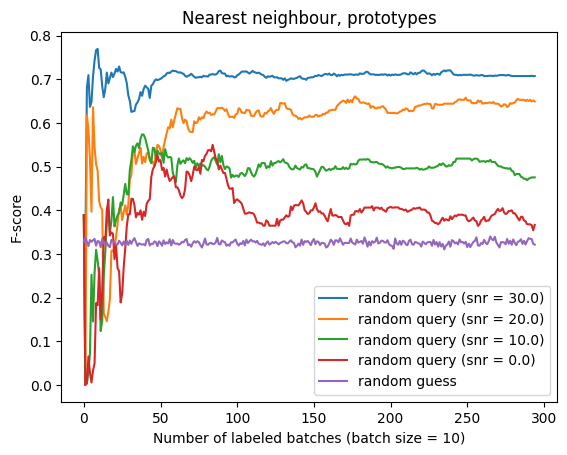

In [23]:
for idx_snr in range(n_snrs):
    snr = snrs[idx_snr]
    mean_accuracies = np.mean(accuracies, axis=0)[idx_snr, :]
    #mean_accuracies = accuracies[20,:,idx_snr]

    plt.plot(mean_accuracies, label='random query (snr = {})'.format(snr))
plt.plot(np.mean(random_accuracies, axis=(0, 1)), label='random guess')
plt.title('Nearest neighbour, prototypes')
plt.legend()
plt.ylabel('F-score')
plt.xlabel('Number of labeled batches (batch size = {})'.format(batch_size))

# Visualize: soundscape, labels and probas

In [24]:
def shift_bit_length(x):
    x = int(x)
    return 1<<(x-1).bit_length()

def next_power_of_2(x):
    return shift_bit_length(x)

idx_run = 0
#idx_snr = 0
#idx_it  = 100
#soundscape_basename = 'soundscape_10'

# TODO: store in folder

results_dir = './results/'

for idx_snr in range(len(snrs)):
    for soundscape_basename in ['soundscape_{}'.format(i) for i in [0, 5, 10, 15, 20]]:
        print(soundscape_basename)
        for idx_it in [0, 1, 10, 100, 250]:
        
            test_base_dir = os.path.join(base_dir, 'test_soundscapes_snr_{}'.format(snrs[idx_snr]))
            test_embeddings, test_labels, all_info = load_annotated_embeddings(test_base_dir)
            
            soundscape_info = []
            # extract the correct info
            for idx_emb, (sc_bn, _, start_time, end_time) in enumerate(all_info):
                if sc_bn == soundscape_basename:
                    #print("timings: ({}, {}), idx_emb: {}".format(start_time, end_time, idx_emb))
                    soundscape_info.append((start_time, end_time, idx_emb))
            soundscape_info = sorted(soundscape_info, key=lambda x: x[0], reverse=False)
            idx_embs = np.array([x[2] for x in soundscape_info])
        
            # extract prediction probabilities and labels
            soundscape_embeddings = test_embeddings[idx_embs]
            soundscape_labels = test_labels[idx_embs]
            probs = probas[idx_run, idx_snr, idx_it]
            pred_probas = probs[idx_embs]
            # embeddings
            emb_window_length = 3.0
            emb_hop_length = 0.5
        
            # align in time
            time_align = int(np.ceil((emb_window_length / 2) / emb_hop_length))
            #print(time_align)
            time_aligned_pred_probas = np.concatenate((np.zeros(time_align), pred_probas[:-1]))
            time_aligned_soundscape_labels = np.concatenate((np.zeros(time_align), soundscape_labels[:-1]))
            
            # extract Mel spectrogram
            window_length = 0.025
            wave, sr = librosa.load(os.path.join(test_base_dir, soundscape_basename + ".wav"))
            mel_spectrogram = librosa.feature.melspectrogram(
                y=wave,
                sr=sr,
                n_fft = next_power_of_2(int(sr * window_length)),
                hop_length = next_power_of_2(int(sr * window_length)) // 2,
            )
            
            fig, ax = plt.subplots(2, 1)
            ax[0].imshow(np.flip(np.log(mel_spectrogram + 1e-10), axis=0), aspect='auto')
            ax[0].set_title("name: {}, iteration: {}, snr: {}".format(soundscape_basename, idx_it, snrs[idx_snr]))
            ax[0].set_xticklabels([])
            ax[1].plot(time_aligned_pred_probas, label='prediction')
            ax[1].plot(time_aligned_soundscape_labels, label='truth')
            ax[1].set_xlim(0, len(time_aligned_soundscape_labels)-1)
            ax[1].set_ylim(0, 1.1)
            ax[1].axhline(0.5, color='red')
            
            xticks = ax[1].get_xticks()
            xtickslabels = np.linspace(0, 30, len(xticks))
            ax[1].set_xticks(xticks)
            ax[1].set_xticklabels(xtickslabels)
            
            plt.legend()
        
            figure_dir = os.path.join(results_dir, 'soundscape_visualiation', 'snr_{}'.format(snrs[idx_snr]), soundscape_basename)
            if not os.path.exists(figure_dir):
                os.makedirs(figure_dir)
            figure_path = os.path.join(figure_dir, '{:05d}'.format(idx_it))
        
            plt.savefig(figure_path)
            plt.cla()
            plt.clf()
            plt.close()

soundscape_0
soundscape_5
soundscape_10
soundscape_15
soundscape_20
soundscape_0
soundscape_5
soundscape_10
soundscape_15
soundscape_20
soundscape_0
soundscape_5
soundscape_10
soundscape_15
soundscape_20
soundscape_0
soundscape_5
soundscape_10
soundscape_15
soundscape_20


# Visualize: probability distribution

In [26]:
idx_run = 0
#idx_snr = 0

for idx_snr in range(len(snrs)):
    for idx_it in [0, 1, 10, 100, 250]:
    
        sns.histplot(probas[idx_run, idx_snr, idx_it], stat='probability')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.title('snr: {}, iteration: {}'.format(snrs[idx_snr], idx_it))
        
        figure_dir = os.path.join(results_dir, 'probability_distribution_visualization', 'snr_{}'.format(snrs[idx_snr]))
        if not os.path.exists(figure_dir):
            os.makedirs(figure_dir)
        figure_path = os.path.join(figure_dir, '{:05d}'.format(idx_it))
        plt.xlabel('pseudo-probability')
        
        plt.savefig(figure_path)
        plt.cla()
        plt.clf()
        plt.close()

/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

# OLD CODE
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [31]:
base_dir = '../soundscapes/ME/'
train_base_dir = os.path.join(base_dir, 'train')
test_base_dir = os.path.join(base_dir, 'test')
train_dataset = datasets.FixedQueryActiveLearningDataset(train_base_dir)
test_embeddings, test_labels = load_annotated_embeddings(test_base_dir)

n_samples = train_dataset.count_labeled() + train_dataset.count_unlabeled()
print("number of unlabaled samples: ", n_samples)

batch_size = 10
n_iterations = (n_samples) // batch_size
print("number of iterations: ", n_iterations)
n_runs = 1
accuracies        = np.zeros((n_runs, n_iterations))
random_accuracies = np.zeros((n_runs, n_iterations))
probas            = np.zeros((n_runs, n_iterations, len(test_embeddings)))

for idx_run in tqdm.tqdm(range(n_runs)):
    _accuracies, _random_accuracies, _probas = random_active_learning_simulation(
        train_base_dir, 
        test_base_dir, 
        n_iterations = n_iterations,
        batch_size = batch_size
    )
    accuracies[idx_run, :] = _accuracies
    random_accuracies[idx_run, :] = _random_accuracies
    probas[idx_run, :, :] = _probas

number of unlabaled samples:  170
number of iterations:  17


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.30it/s]

train dir:  ../soundscapes/ME/train
test dir:  ../soundscapes/ME/test
unlabaled datapoints:  170
unlabaled datapoints:  160
unlabaled datapoints:  150
unlabaled datapoints:  140
unlabaled datapoints:  130
unlabaled datapoints:  120
unlabaled datapoints:  110
unlabaled datapoints:  100
unlabaled datapoints:  90
unlabaled datapoints:  80
unlabaled datapoints:  70
unlabaled datapoints:  60
unlabaled datapoints:  50
unlabaled datapoints:  40
unlabaled datapoints:  30
unlabaled datapoints:  20
unlabaled datapoints:  10


Text(0.5, 0, 'Number of labeled batches (batch_size = 10)')

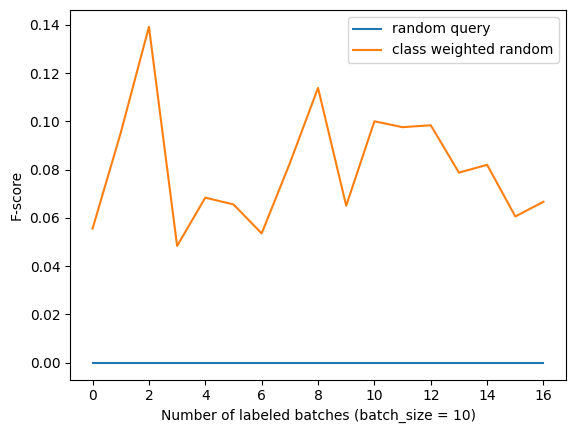

In [32]:
mean_accuracies = np.mean(accuracies, axis=0)
plt.plot(mean_accuracies, label='random query'.format(snr))
plt.plot(np.mean(random_accuracies, axis=0), label='class weighted random')
plt.legend()
plt.ylabel('F-score')
plt.xlabel('Number of labeled batches (batch_size = {})'.format(batch_size))

/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'snr = -10.0')

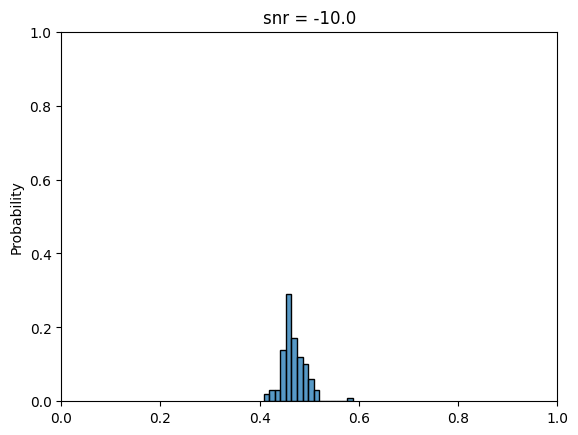

In [58]:
idx_iteration = 99
idx_run = 0
idx_snr = 3
#print(probas[idx_run, idx_iteration, idx_snr])

sns.histplot(probas[idx_run, idx_iteration, idx_snr], stat='probability')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('snr = {}'.format(snrs[idx_snr]))

In [6]:
base_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/'
train_base_dir = os.path.join(base_dir, 'train_soundscapes')
test_base_dir = os.path.join(base_dir, 'test_soundscapes')

wav_file_paths = glob.glob(os.path.join(train_base_dir, '*.wav'))
for wav_file_path in wav_file_paths:
    wave, sr = librosa.load(wav_file_path)
    print(wav_file_path, len(wave) / sr)

/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_4.wav 60.0
/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_2.wav 60.0
/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_0.wav 60.0
/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_3.wav 60.0
/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_1.wav 60.0


In [7]:
embedding_file_paths = glob.glob(os.path.join(train_base_dir, '*.embeddings.txt'))
for embedding_file_path in embedding_file_paths:
    print(embedding_file_path)

/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_4.birdnet.embeddings.txt
/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_1.birdnet.embeddings.txt
/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_0.birdnet.embeddings.txt
/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_2.birdnet.embeddings.txt
/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_3.birdnet.embeddings.txt


In [8]:
def load_timings_and_embeddings(file_path, embedding_dim=1024):
    timings_and_embeddings = []
    with open(file_path, 'r') as f:
        data = f.readlines()
        for d in data:
            _d = d.split('\t')
            start_time = _d[0]
            end_time = _d[1]
            embedding = np.zeros(embedding_dim)
            values = _d[2].split(',')
            assert(len(embedding) == len(values))
            for i, value in enumerate(values):
                embedding[i] = float(value)
            timings_and_embeddings.append((float(start_time), float(end_time), embedding))
    return timings_and_embeddings

In [9]:
timings_and_embeddings = load_timings_and_embeddings(embedding_file_paths[0])
for (start_time, end_time, embedding) in timings_and_embeddings:
    print(start_time, end_time, embedding)

0.0 3.0 [0.         0.         1.7393581  ... 0.81265146 0.         0.21352522]
3.0 6.0 [0.         0.         1.7580944  ... 0.54463536 0.12631564 0.34642538]
6.0 9.0 [0.07568493 0.         1.8502065  ... 0.91698384 0.06981349 0.36680654]
9.0 12.0 [0.10101729 0.         1.606492   ... 0.32422802 0.         0.21287394]
12.0 15.0 [0.         0.         2.0086942  ... 0.45750746 0.         0.12314761]
15.0 18.0 [0.02589745 0.         1.8218488  ... 0.05516787 0.         0.6835616 ]
18.0 21.0 [0.1490773  0.         1.0731277  ... 0.12980612 0.         0.15583007]
21.0 24.0 [0.07470297 0.         2.8355272  ... 0.06235139 0.         0.11773118]
24.0 27.0 [0.         0.         1.497625   ... 0.2350638  0.         0.15168528]
27.0 30.0 [0.        0.        0.4959681 ... 0.0772132 0.        0.       ]
30.0 33.0 [0.        0.        1.1467043 ... 0.5396828 0.        0.7398694]
33.0 36.0 [0.        0.        1.5867515 ... 0.1376795 0.        1.1339625]
36.0 39.0 [0.1162579 0.        1.793461  

In [10]:
train_data = {}
labeled_train_data = {}

# Thought: this becomes tricky for dynamic timings
for embedding_file_path in embedding_file_paths:
    timings_and_embeddings = load_timings_and_embeddings(embedding_file_path)
    train_data[os.path.basename(embedding_file_path)] = timings_and_embeddings
    labeled_train_data[os.path.basename(embedding_file_path)] = np.zeros(len(timings_and_embeddings))

In [11]:
annotation_file_paths = glob.glob(os.path.join(train_base_dir, '*.txt'))
annotation_file_paths = list(filter(lambda x: not "embedding" in x, annotation_file_paths))

In [12]:
def class_name2class_id(class_name):
    if 'bg' in class_name:
        return 0
    elif 'fg' in class_name:
        return 1

def load_annotations(file_path):
    annotations = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for l in lines:
            d = l.split('\t')
            start_time = float(d[0])
            end_time = float(d[1])
            c = class_name2class_id(d[2])
            #print(start_time, end_time, c)
            annotations.append((start_time, end_time, c))
    return annotations

idx = 2
print(annotation_file_paths[idx])
load_annotations(annotation_file_paths[idx])

/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes/soundscape_1.txt


[(26.098842186458548, 26.248842186458546, 1),
 (37.18741308181116, 37.33741308181116, 1),
 (42.30806006548569, 42.45806006548569, 1),
 (43.35587082656047, 43.50587082656047, 1),
 (46.94045246866103, 47.09045246866103, 1)]

In [13]:
# TODO: is the embedding association done correctly?
class FixedQueryActiveLearningDataset:
    def __init__(self, base_dir):
        embedding_file_paths = glob.glob(os.path.join(base_dir, '*.embeddings.txt'))

        self.train_data = {}
        self.labeled_train_data = {}
        
        # Thought: this becomes tricky for dynamic timings
        for embedding_file_path in embedding_file_paths:
            timings_and_embeddings = load_timings_and_embeddings(embedding_file_path)
            self.train_data[os.path.basename(embedding_file_path).split('.')[0]] = timings_and_embeddings
            self.labeled_train_data[os.path.basename(embedding_file_path).split('.')[0]] = np.zeros(len(timings_and_embeddings))-1

    def count_labeled(self):
        count = 0
        for key in self.labeled_train_data.keys():
            indices = np.where(self.labeled_train_data[key] >= 0)[0]
            count += len(indices)
        return count

    def count_unlabeled(self):
        count = 0
        for key in self.labeled_train_data.keys():
            indices = np.where(self.labeled_train_data[key] == -1)[0]
            count += len(indices)
        return count

    def add_query_label(self, key, idx, label):
        self.labeled_train_data[key][idx] = label
    
    def random_query(self):
        queries = []
        for key in self.labeled_train_data.keys():
            indices = np.where(self.labeled_train_data[key] == -1)
            for idx in indices[0]:
                queries.append((key, idx))

        query_idx = np.random.randint(len(queries))
        (key, idx) = queries[query_idx]
        
        return (key, idx), self.train_data[key][idx]

class AdaptiveQueryActiveLearningDataset:
    def __init__(self, base_dir):
        embedding_file_paths = glob.glob(os.path.join(base_dir, '*.embeddings.txt'))
    
class Oracle:
    def __init__(self, base_dir):
        annotation_file_paths = glob.glob(os.path.join(base_dir, '*.txt'))
        annotation_file_paths = list(filter(lambda x: not "embedding" in x, annotation_file_paths))

        self.annotations = {}

        for annotation_file_path in annotation_file_paths:
            key = os.path.basename(annotation_file_path).split('.')[0]
            self.annotations[key] = load_annotations(annotation_file_path)
            #print(key, self.annotations[key])
            
    def query(self, start_time, end_time, soundscape_basename):
        ann = self.annotations[soundscape_basename]
        #print("ann: ", ann)
        #print("query times: ", start_time, end_time)
        for (a_start_time, a_end_time, c) in ann:
            #print("ann times: ", a_start_time, a_end_time, c)
            if a_start_time >= start_time and a_end_time <= end_time:
                return c
        return 0

In [14]:
oracle = Oracle(train_base_dir)
fixed_al_dataset = FixedQueryActiveLearningDataset(train_base_dir)
print("labeled: ", fixed_al_dataset.count_labeled())
print("unlabeled: ", fixed_al_dataset.count_unlabeled())
(soundscape_basename, idx), (start_time, end_time, embedding) = fixed_al_dataset.random_query()
label = oracle.query(start_time, end_time, soundscape_basename)
fixed_al_dataset.add_query_label(soundscape_basename, idx, label)
print("labeled: ", fixed_al_dataset.count_labeled())
print("unlabeled: ", fixed_al_dataset.count_unlabeled())

labeled:  0
unlabeled:  100
labeled:  1
unlabeled:  99


In [18]:
import sklearn.metrics

In [54]:
all_embeddings = []
all_labels = []

oracle = Oracle(train_base_dir)
train_dataset = FixedQueryActiveLearningDataset(train_base_dir)

iteration_count = 0

accuracies = []
random_accuracies = []
n_iterations = train_dataset.count_labeled() + train_dataset.count_unlabeled()
test_embeddings, test_labels = load_annotated_embeddings(test_base_dir)
probas = np.zeros((n_iterations, len(test_embeddings)))
while train_dataset.count_unlabeled() > 0:
    # get random query
    (soundscape_basename, idx), (start_time, end_time, embedding) = train_dataset.random_query()

    # annotate query
    label = oracle.query(start_time, end_time, soundscape_basename)

    # update active learning dataset with label
    train_dataset.add_query_label(soundscape_basename, idx, label)

    all_embeddings.append(embedding)
    all_labels.append(label)

    _all_labels = np.array(all_labels)
    _all_embeddings = np.array(all_embeddings)

    pos_embeddings = _all_embeddings[_all_labels == 1]
    neg_embeddings = _all_embeddings[_all_labels == 0]

    if len(pos_embeddings) > 0 and len(neg_embeddings) > 0:
        p_prototype = np.mean(pos_embeddings, axis=0)
        n_prototype = np.mean(neg_embeddings, axis=0)

        test_predictions = []
        for idx_emb, query_embedding in enumerate(test_embeddings):
            proba = probability_query(query_embedding, n_prototype=n_prototype, p_prototype=p_prototype, temp=1)
            probas[iteration_count, idx_emb] = proba
            # TODO: something is wierd with the pseudo-probability, it seems like class association is not correct
            test_predictions.append(int(proba >= 0.5))
        test_predictions = np.array(test_predictions)

        accuracy = sklearn.metrics.f1_score(test_predictions, test_labels) #np.mean(test_predictions == test_labels)
        accuracies.append(accuracy)
    else:
        accuracy = 0
        accuracies.append(accuracy)

    random_accuracies.append(sklearn.metrics.f1_score(np.random.choice([0, 1], p=[0.78, 0.22], size=len(test_labels)), test_labels))
        

    print("-----------------------------------------")
    print("iteration_count: ", iteration_count)
    print("number of positive: ", len(pos_embeddings))
    print("number of negative: ", len(neg_embeddings))
    print("accuracy: ", accuracy)

    iteration_count+=1

all_embeddings = np.array(all_embeddings)
#all_labels = np.array(all_labels)
print(all_embeddings.shape)
#print(all_labels.shape)

-----------------------------------------
iteration_count:  0
number of positive:  0
number of negative:  1
accuracy:  0
-----------------------------------------
iteration_count:  1
number of positive:  0
number of negative:  2
accuracy:  0
-----------------------------------------
iteration_count:  2
number of positive:  0
number of negative:  3
accuracy:  0
-----------------------------------------
iteration_count:  3
number of positive:  0
number of negative:  4
accuracy:  0
-----------------------------------------
iteration_count:  4
number of positive:  0
number of negative:  5
accuracy:  0
-----------------------------------------
iteration_count:  5
number of positive:  0
number of negative:  6
accuracy:  0
-----------------------------------------
iteration_count:  6
number of positive:  0
number of negative:  7
accuracy:  0
-----------------------------------------
iteration_count:  7
number of positive:  0
number of negative:  8
accuracy:  0
--------------------------------

final F-score:  0.8518518518518519


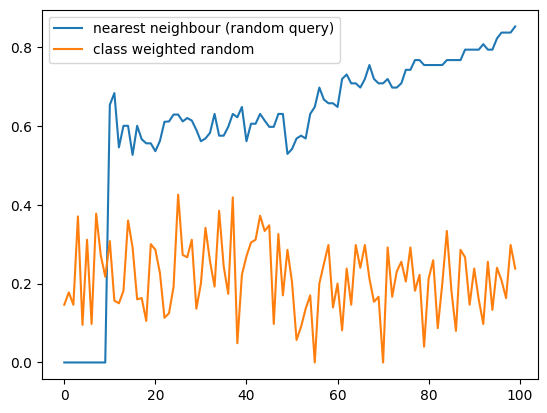

In [56]:
import matplotlib.pyplot as plt
plt.plot(accuracies, label='nearest neighbour (random query)')
plt.plot(random_accuracies, label='class weighted random')
plt.legend()
print("final F-score: ", accuracies[-1])

[0.6423177  0.48572897 0.47840873 0.51170461 0.45555125 0.45263124
 0.46936117 0.77434355 0.49636017 0.78672723 0.46556585 0.51044573
 0.44795616 0.43047532 0.46694296 0.45263124 0.72357492 0.47378622
 0.47135819 0.47223425 0.71083667 0.45650944 0.40960265 0.44344679
 0.4790078  0.65891731 0.60376311 0.46473235 0.60792987 0.41284942
 0.50690779 0.45147201 0.44332541 0.45059952 0.72848115 0.46136347
 0.46182256 0.45383899 0.45702374 0.66558594 0.44274981 0.46672133
 0.6693483  0.4460296  0.46898325 0.48384668 0.4460296  0.49552241
 0.52801825 0.4858923  0.69973237 0.58336574 0.66676926 0.46688301
 0.72643386 0.45752535 0.59971135 0.48905457 0.76226506 0.48315656
 0.46694296 0.62201611 0.57437227 0.45882139 0.66501231 0.45670769
 0.52801825 0.55871683 0.49067413 0.47048838 0.50368311 0.50368311
 0.49746091 0.45481466 0.44329025 0.45879086 0.46936117 0.4858923
 0.44811722 0.47147923 0.46351864 0.49574589 0.44344679 0.40960265
 0.77885846 0.45882118 0.48197203 0.46688301 0.5776476  0.44598

/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 1.0)

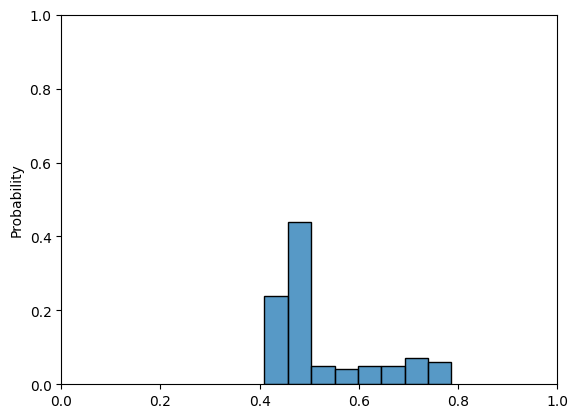

In [35]:
idx = 95
print(probas[idx])
sns.histplot(probas[idx], stat='probability')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [36]:
for idx, query_embedding in enumerate(test_embeddings):
    print('-----------------------------------------')
    print("label: ", test_labels[idx])
    print("d_n: ", euclidean_distance(query_embedding, n_prototype))
    print("d_p: ", euclidean_distance(query_embedding, p_prototype))
    print("proba: ", probability_query(query_embedding, n_prototype, p_prototype))
    print('-----------------------------------------')
    

-----------------------------------------
label:  1
d_n:  14.183481625964076
d_p:  13.657429176923358
proba:  0.6285619387252368
-----------------------------------------
-----------------------------------------
label:  0
d_n:  13.253503947871899
d_p:  13.353247059848746
proba:  0.4750848746497717
-----------------------------------------
-----------------------------------------
label:  0
d_n:  13.568243733534667
d_p:  13.664920681639742
proba:  0.4758495700741214
-----------------------------------------
-----------------------------------------
label:  0
d_n:  15.084834190670303
d_p:  15.091964556922816
proba:  0.498217415989395
-----------------------------------------
-----------------------------------------
label:  0
d_n:  14.728497993208757
d_p:  14.91498231906689
proba:  0.4535135597838499
-----------------------------------------
-----------------------------------------
label:  0
d_n:  14.065335836190492
d_p:  14.292713997667672
proba:  0.44339910917174824
-----------------

In [37]:
print(n_prototype)
print(p_prototype)

[0.03116123 0.01042356 1.77333725 ... 0.36804388 0.05609098 0.82399955]
[5.04974137e-02 1.48698825e-03 1.51070567e+00 ... 4.48050604e-01
 4.61812413e-02 3.27030560e-01]


In [30]:
import sklearn.manifold
import sklearn.decomposition

reduction_method = 'TSNE'

print(train_base_dir)
train_embeddings, train_labels = load_annotated_embeddings(train_base_dir)

if reduction_method == 'TSNE':
    tsne = sklearn.manifold.TSNE(n_components=2)
    results = tsne.fit_transform(train_embeddings)

if reduction_method == 'PCA':
    pca = sklearn.decomposition.PCA(n_components=2)
    results = pca.fit_transform(train_embeddings)
print(results.shape)

/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/BV/AMRE/train_soundscapes
(100, 2)


/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

<Axes: >

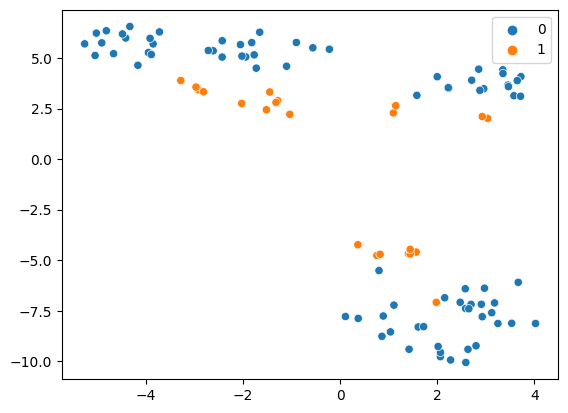

In [31]:
import seaborn as sns
x = [e[0] for e in results]
y = [e[1] for e in results]
hue = train_labels

sns.scatterplot(x = x, y = y, hue=hue)

In [131]:
len(train_labels)

100